In [11]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import collections as c
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 30}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
import random
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
import warnings
warnings.filterwarnings('ignore')

In [12]:
log_reg_model = pickle.load(open('logistic_regression_completion_third_quarter.p', 'rb')) # load the model

In [13]:
log_reg_model.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')>

In [14]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)

def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='blue', 
         lw=3)
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [15]:
X_test = pd.read_csv('../data/processed/third_quarter/X_test.csv')
y_test = pd.read_csv('../data/processed/third_quarter/y_test.csv')
y_test = y_test['module_not_completed']

numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'sum_click_dataplus', 'sum_click_dualpane', 'sum_click_externalquiz', 'sum_click_forumng','sum_click_glossary', 'sum_click_homepage', 'sum_click_htmlactivity', 'sum_click_oucollaborate', 'sum_click_oucontent', 'sum_click_ouelluminate', 'sum_click_ouwiki', 'sum_click_page', 'sum_click_questionnaire', 'sum_click_quiz', 'sum_click_repeatactivity', 'sum_click_resource', 'sum_click_sharedsubpage', 'sum_click_subpage', 'sum_click_url', 'sum_days_vle_accessed', 'max_clicks_one_day', 'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment', 'score_first_assessment']

# fill and scale
X_test.fillna(value = 0, inplace = True)
X_test = scale_subset(X_test, numeric_cols)

high_vif = ['module_presentation_length', 'sum_days_vle_accessed', 'score_first_assessment', 'days_early_first_assessment']
X_test.drop(high_vif, axis = 1, inplace = True)

In [17]:
t = 0.5 # threshold for predicting positive

In [29]:
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = log_reg_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    class_report = classification_report(y_test, predictions)

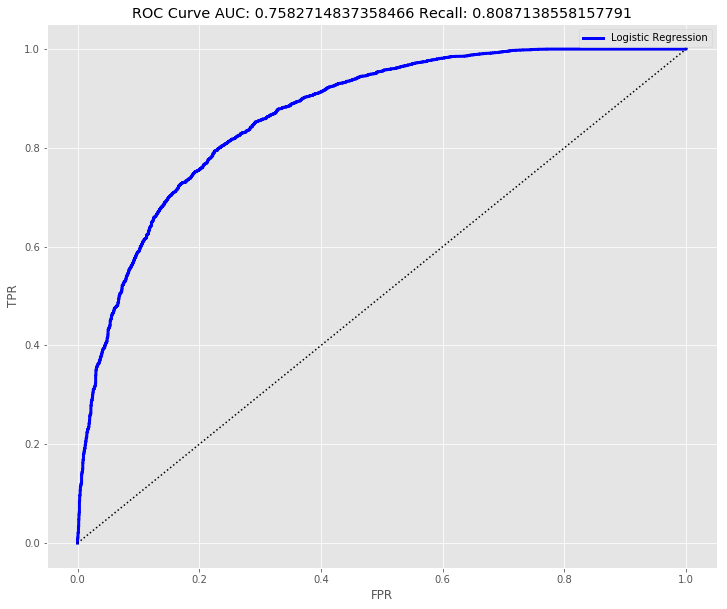

Best Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')

Roc Auc: 0.7582714837358466

Recall Score: 0.8087138558157791

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.91      0.86      5093
        True       0.77      0.61      0.68      2550

   micro avg       0.81      0.81      0.81      7643
   macro avg       0.80      0.76      0.77      7643
weighted avg       0.81      0.81      0.80      7643


Confusion Matrix:
 [[1547  459]
 [1003 4634]]


In [21]:
    print_roc_curve(y_test, probas, 'Logistic Regression')
    print('Best Model: {}'.format(log_reg_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

## Model Improvement Over Baseline

In [22]:
proportion = y_test.sum() / y_test.shape[0]

In [23]:
# randomly pedict ~1/3 = true
proportion = 0.33567943348158386
baseline_preds = []
for n in range(len(y_test)):
    if random.random() < proportion:
        baseline_preds.append(True)
    else:
        baseline_preds.append(False)

In [24]:
baseline_probas = np.array([proportion] * len(y_test))

In [25]:
    predictions = baseline_preds
    roc_auc = roc_auc_score(y_test, predictions)
    probas = baseline_probas
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

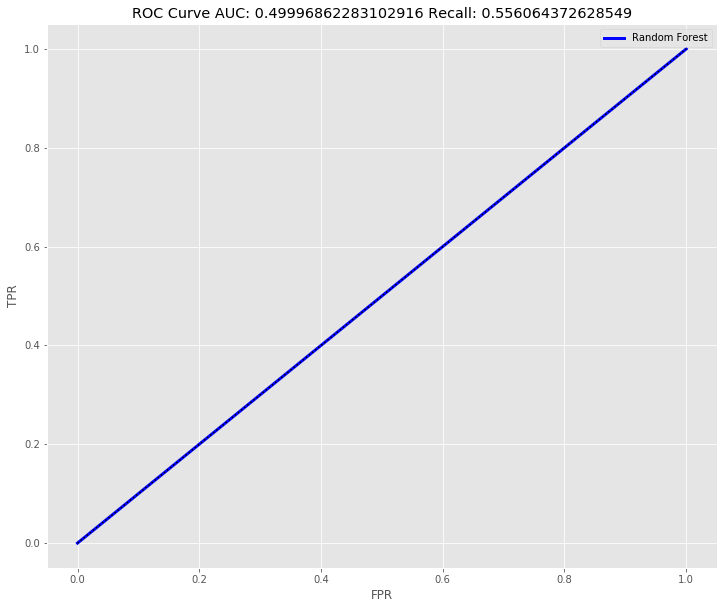

Best Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')

Roc Auc: 0.49996862283102916

Recall Score: 0.556064372628549

Classification Report:
               precision    recall  f1-score   support

       False       0.67      0.67      0.67      5093
        True       0.33      0.33      0.33      2550

   micro avg       0.56      0.56      0.56      7643
   macro avg       0.50      0.50      0.50      7643
weighted avg       0.56      0.56      0.56      7643


Confusion Matrix:
 [[ 845 1688]
 [1705 3405]]


In [26]:
    print_roc_curve(y_test, probas, 'Random Forest')
    print('Best Model: {}'.format(log_reg_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

## Feature Importance

In [27]:
    # Feature Importances
    abs_coef = list(np.abs(log_reg_model.coef_.ravel()))
    features = list(X_test.columns)
    coef_dict = c.OrderedDict((zip(abs_coef, features)))
    print('The top twenty features affecting completion are:\n')
    sorted(coef_dict.items(), reverse=True)[:20]

The top twenty features affecting completion are:



[(1.6989553886321587, 'code_module_EEE'),
 (1.5268222992427853, 'code_module_FFF'),
 (1.4213832834253077, 'avg_score'),
 (1.2775720855127528, 'code_module_CCC'),
 (1.026655818489303, 'code_module_DDD'),
 (0.8249931359728049, 'sum_click_oucontent'),
 (0.8050994394439146, 'imd_band_nan'),
 (0.7161945645418704, 'age_band_55<='),
 (0.6283411845324854, 'sum_click_ouwiki'),
 (0.6232689767875371, 'sum_click_folder'),
 (0.6043384155800321, 'code_presentation_2014J'),
 (0.498689049577955, 'imd_band_90-100%'),
 (0.4917447431563873, 'highest_education_Lower Than A Level'),
 (0.4783544338916498, 'sum_click_homepage'),
 (0.45572877977871545, 'imd_band_60-70%'),
 (0.412795410584947, 'sum_click_quiz'),
 (0.41171247724280113, 'highest_education_No Formal quals'),
 (0.3503144468049271, 'sum_click_page'),
 (0.3258626691692949, 'imd_band_80-90%'),
 (0.3051949176832568, 'imd_band_30-40%')]

## Choosing a Threshold

In [31]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:100]

,fprs,tprs,Thresholds
800,0.189020,0.745337,0.711092
900,0.220000,0.781857,0.677680
1000,0.250588,0.814255,0.645004
1100,0.284314,0.841547,0.611393
1200,0.317255,0.866483,0.577082
1300,0.350588,0.888082,0.543318
1400,0.388627,0.908109,0.503380
1500,0.427059,0.929118,0.454051
1600,0.476078,0.946790,0.402628
1700,0.523529,0.961516,0.350188


In [32]:
    t = 0.5 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

       False       0.82      0.91      0.86      5093
        True       0.77      0.61      0.68      2550

   micro avg       0.81      0.81      0.81      7643
   macro avg       0.80      0.76      0.77      7643
weighted avg       0.81      0.81      0.80      7643


Confusion Matrix at Threshold 0.5:
 [[1547  459]
 [1003 4634]]


In [35]:
    t = 0.4 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.4:
               precision    recall  f1-score   support

       False       0.85      0.85      0.85      5093
        True       0.70      0.71      0.71      2550

   micro avg       0.80      0.80      0.80      7643
   macro avg       0.78      0.78      0.78      7643
weighted avg       0.80      0.80      0.80      7643


Confusion Matrix at Threshold 0.4:
 [[1807  762]
 [ 743 4331]]


In [36]:
    t = 0.3 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.3:
               precision    recall  f1-score   support

       False       0.88      0.76      0.81      5093
        True       0.62      0.80      0.70      2550

   micro avg       0.77      0.77      0.77      7643
   macro avg       0.75      0.78      0.76      7643
weighted avg       0.80      0.77      0.78      7643


Confusion Matrix at Threshold 0.3:
 [[2036 1238]
 [ 514 3855]]
